In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

## **Introduction:**

**Although IBM’s Deep Blue supercomputer beat the chess world champion Garry Kas‐
parov back in 1996, it wasn’t until fairly recently that computers were able to reliably
perform seemingly trivial tasks such as detecting a puppy in a picture or recognizing
spoken words. Why are these tasks so effortless to us humans? The answer lies in the
fact that perception largely takes place outside the realm of our consciousness, within
specialized visual, auditory, and other sensory modules in our brains. By the time
sensory information reaches our consciousness, it is already adorned with high-level
features; for example, when you look at a picture of a cute puppy, you cannot choose
not to see the puppy, or not to notice its cuteness. Nor can you explain how you rec‐
ognize a cute puppy; it’s just obvious to you. Thus, we cannot trust our subjective
experience: perception is not trivial at all, and to understand it we must look at how
the sensory modules work.
Convolutional neural networks (CNNs) emerged from the study of the brain’s visual
cortex, and they have been used in image recognition since the 1980s. In the last few
years, thanks to the increase in computational power, the amount of available training
data, and the tricks presented in Chapter 11 for training deep nets, CNNs have man‐
aged to achieve superhuman performance on some complex visual tasks. They power
image search services, self-driving cars, automatic video classification systems, and
more. Moreover, CNNs are not restricted to visual perception: they are also successful
at many other tasks, such as voice recognition or natural language processing (NLP);
however, we will focus on visual applications for now.**

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## **Convolutional Architecture Exploration**

**Let’s look at a simple example. The following code loads two sample images, using
Scikit-Learn’s load_sample_images() (which loads two color images, one of a Chi‐
nese temple, and the other of a flower). The pixel intensities (for each color channel)
is represented as a byte from 0 to 255, so we scale these features simply by dividing by
255, to get floats ranging from 0 to 1. Then we create two 7 × 7 filters (one with a
vertical white line in the middle, and the other with a horizontal white line in the
middle), and we apply them to both images using the tf.nn.conv2d() function,
which is part of TensorFlow’s low-level Deep Learning API. In this example, we use
zero padding ( padding="SAME" ) and a stride of 2**

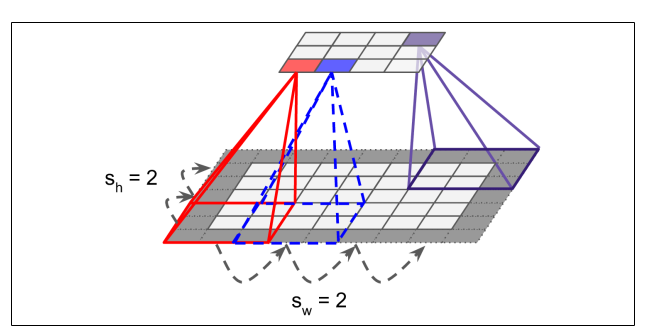

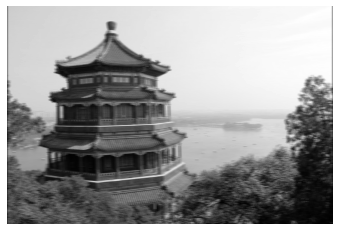

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # horizontal and vertical centred filters 
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME") # adding zero panding to garantie the same size of every neuron's receptive fields

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

• images is the input mini-batch (a 4D tensor, as explained earlier).


• filters is the set of filters to apply (also a 4D tensor, as explained earlier).


• strides is equal to 1, but it could also be a 1D array with 4 elements, where the
two central elements are the vertical and horizontal strides (s h and s w ). The first
and last elements must currently be equal to 1. They may one day be used to
specify a batch stride (to skip some instances) and a channel stride (to skip some
of the previous layer’s feature maps or channels).


• padding must be either "VALID" or "SAME" :



— If set to "VALID" , the convolutional layer does not use zero padding, and may
ignore some rows and columns at the bottom and right of the input image,
depending on the stride, as shown in Figure 14-7 (for simplicity, only the hor‐
izontal dimension is shown here, but of course the same logic applies to the
vertical dimension).


— If set to "SAME" , the convolutional layer uses zero padding if necessary. In this
case, the number of output neurons is equal to the number of input neurons
divided by the stride, rounded up (in this example, 13 / 5 = 2.6, rounded up to
3). Then zeros are added as evenly as possible around the inputs.**

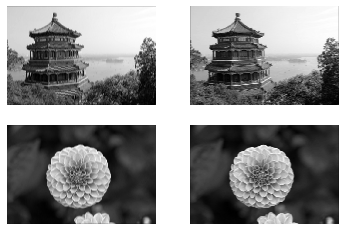

In [ ]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

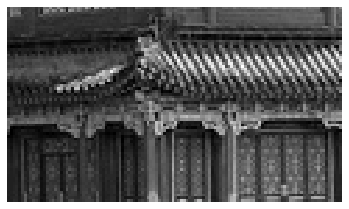

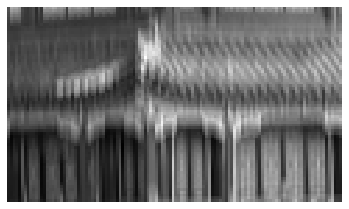

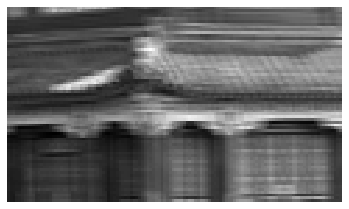

In [ ]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()
# original one then vertical filtering then horizontal filtering


## **Showing filters**

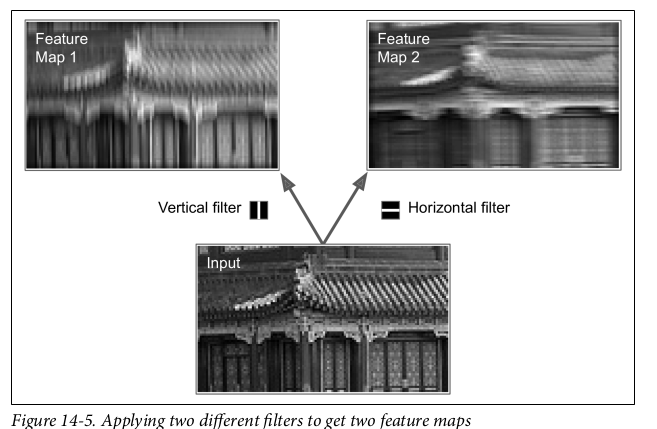

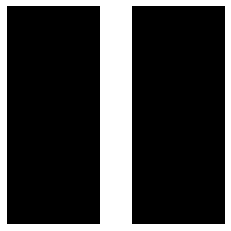

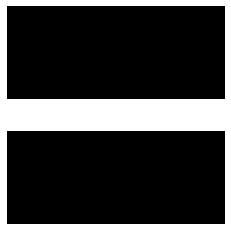

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## **Convolutional layer Explained**

**In this example, we manually defined the filters, but in a real CNN you would normally define filters as trainable variables, so the neural net can learn which filters
work best, as explained earlier. Instead of manually creating the variables, however,
you can simply use the keras.layers.Conv2D layer:**



```
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
padding="SAME", activation="relu")

```



**This code creates a Conv2D layer with 32 filters, each 3 × 3, using a stride of 1 (both
horizontally and vertically), SAME padding, and applying the ReLU activation func‐
tion to its outputs. As you can see, convolutional layers have quite a few hyperpara‐
meters: you must choose the number of filters, their height and width, the strides, and
the padding type. As always, you can use cross-validation to find the right hyperpara‐
meter values, but this is very time-consuming.**

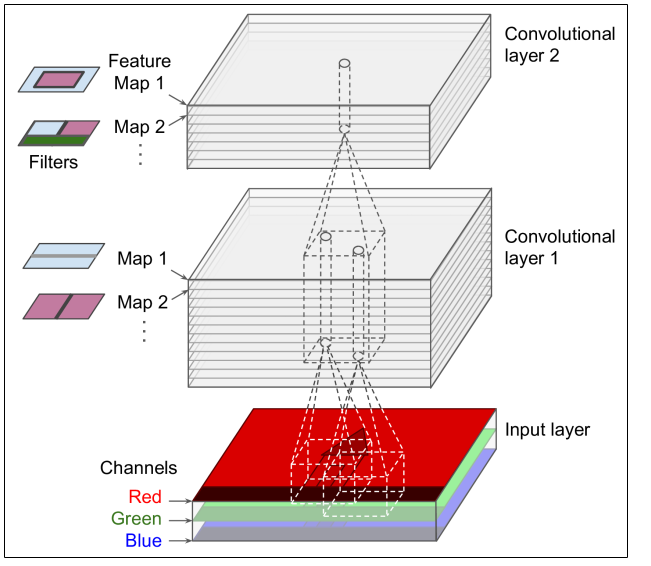

In [ ]:
# Let's create a 2D convolutional layer, using keras.layers.Conv2D():

np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

In [ ]:
# passing it the two test images:

conv_outputs = conv(images)
conv_outputs.shape 



TensorShape([2, 427, 640, 2])

**The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since padding="SAME" and strides=1, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.**

**Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:**


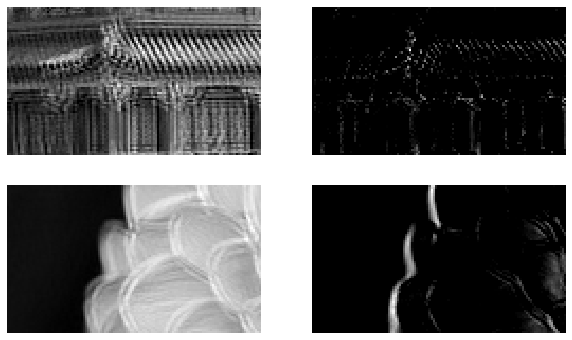

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

**Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing.**

**If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):**


In [ ]:
conv.set_weights([filters, np.zeros(2)])

#Now let's call this layer again on the same two images, and let's check that the output feature maps do highlight vertical lines and horizontal lines, respectively (as earlier):
conv_outputs = conv(images)
conv_outputs.shape 


TensorShape([2, 427, 640, 2])

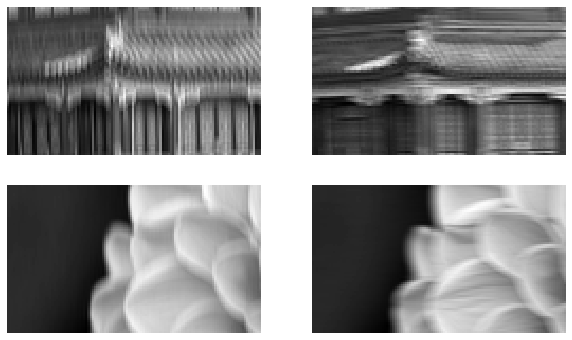

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()


## **VALID vs SAME padding**

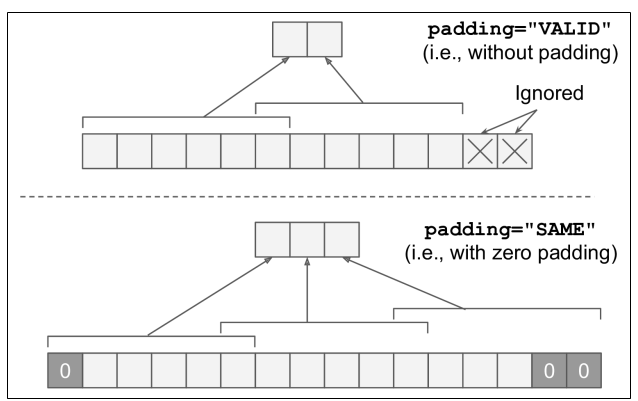


In [ ]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images



In [ ]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

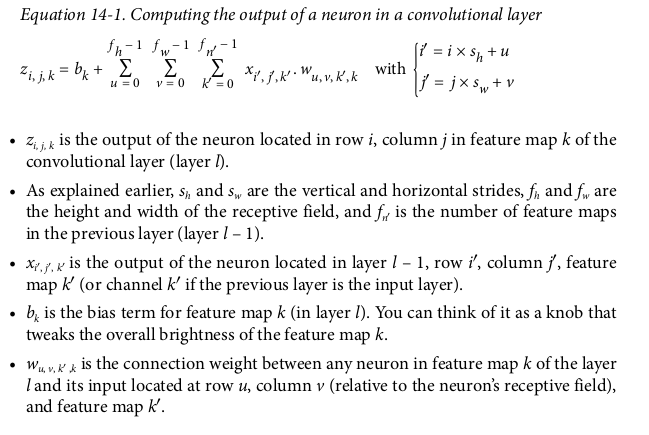

## **Memory Requirements**


**Another problem with CNNs is that the convolutional layers require a huge amount
of RAM. This is especially true during training, because the reverse pass of backpro‐
pagation requires all the intermediate values computed during the forward pass.
For example, consider a convolutional layer with 5 × 5 filters, outputting 200 feature
maps of size 150 × 100, with stride 1 and SAME padding. If the input is a 150 × 100 image (three channels), then the number of parameters is (5 × 5 × 3 + 1) × 200
= 15,200 (the +1 corresponds to the bias terms), which is fairly small compared to a
fully connected layer. 7 However, each of the 200 feature maps contains 150 × 100 neu‐
rons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 =
75 inputs: that’s a total of 225 million float multiplications. Not as bad as a fully con‐
nected layer, but still quite computationally intensive. Moreover, if the feature maps
are represented using 32-bit floats, then the convolutional layer’s output will occupy
200 × 150 × 100 × 32 = 96 million bits (12 MB) of RAM. 8 And that’s just for one
instance! If a training batch contains 100 instances, then this layer will use up 1.2 GB
of RAM!**


**During inference (i.e., when making a prediction for a new instance) the RAM occu‐
pied by one layer can be released as soon as the next layer has been computed, so you
only need as much RAM as required by two consecutive layers. But during training
everything computed during the forward pass needs to be preserved for the reverse
pass, so the amount of RAM needed is (at least) the total amount of RAM required by
all layers.**


**If training crashes because of an out-of-memory error, you can try
reducing the mini-batch size. Alternatively, you can try reducing
dimensionality using a stride, or removing a few layers. Or you can
try using 16-bit floats instead of 32-bit floats. Or you could distrib‐
ute the CNN across multiple devices.**

## **Pooling layer**

**A pooling neuron has no weights; all it does is aggregate the
inputs using an aggregation function such as the max or mean. Figure 14-8 shows a
max pooling layer, which is the most common type of pooling layer.**

**In this example, we use a 2 × 2 _pooling kernel_ 9 , with a stride of 2, and no padding. Only the max
input value in each receptive field makes it to the next layer, while the other inputs
are dropped. For example, in the lower left receptive field in Figure 14-8, the input
values are 1, 5, 3, 2, so only the max value, 5, is propagated to the next layer. Because
of the stride of 2, the output image has half the height and half the width of the input
image (rounded down since we use no padding).**

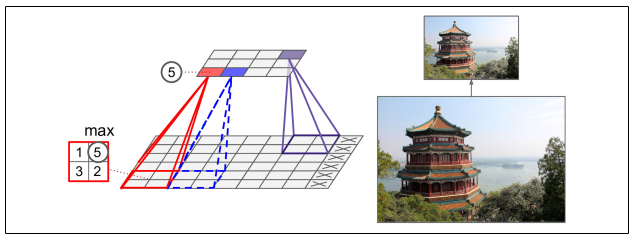

**Max Pooling**

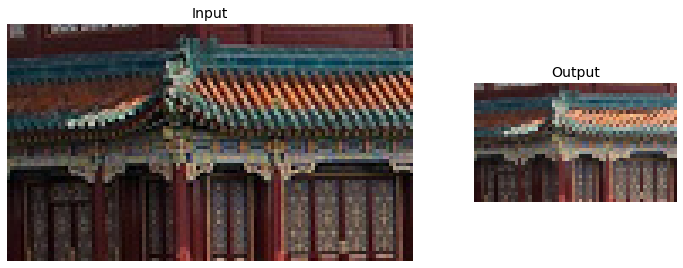

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
#To create an average pooling layer, just use AvgPool2D instead of MaxPool2D

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()



## **Invariance with pooling layers**

**By inserting a max pooling layer every few layers in
a CNN, it is possible to get some level of translation invariance at a larger scale.
Moreover, max pooling also offers a small amount of rotational invariance and a
slight scale invariance. Such invariance (even if it is limited) can be useful in cases
where the prediction should not depend on these details, such as in classification
tasks.**

## **Average vs Max pooling**

**Average pooling layers used to be very popular, but people
mostly use max pooling layers now, as they generally perform better. This may seem
surprising, since computing the mean generally loses less information than comput‐
ing the max. But on the other hand, max pooling preserves only the strongest feature,
getting rid of all the meaningless ones, so the next layers get a cleaner signal to work
with. Moreover, max pooling offers stronger translation invariance than average
pooling.**


**Note that max pooling and average pooling can be performed along the depth dimen‐
sion rather than the spatial dimensions, although this is not as common. This can
allow the CNN to learn to be invariant to various features. For example, it could learn
multiple filters, each detecting a different rotation of the same pattern, such as hand-
written digits (see Figure 14-10), and the depth-wise max pooling layer would ensure
that the output is the same regardless of the rotation. The CNN could similarly learn
to be invariant to anything else: thickness, brightness, skew, color, and so on.**

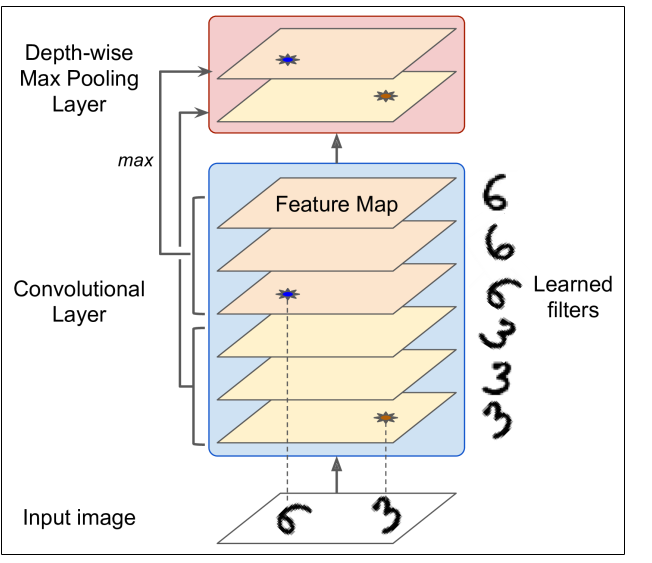

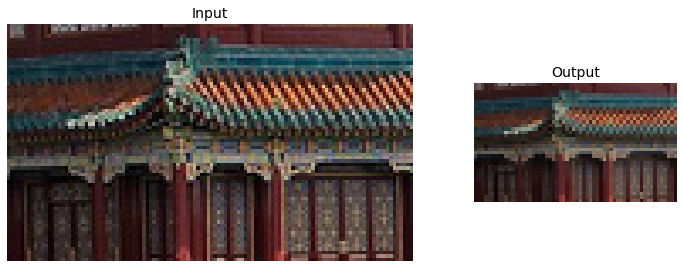

In [ ]:
# average pooling

avg_pool = keras.layers.AvgPool2D(pool_size=2)

output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()



### **Global average pooling and Depth wise pooling**

skipped

## **CNN Architectures**

**Typical CNN architectures stack a few convolutional layers (each one generally fol‐
lowed by a ReLU layer), then a pooling layer, then another few convolutional layers
(+ReLU), then another pooling layer, and so on. The image gets smaller and smaller
as it progresses through the network, but it also typically gets deeper and deeper (i.e.,
with more feature maps) thanks to the convolutional layers (see Figure 14-11). At the
top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a
softmax layer that outputs estimated class probabilities).**

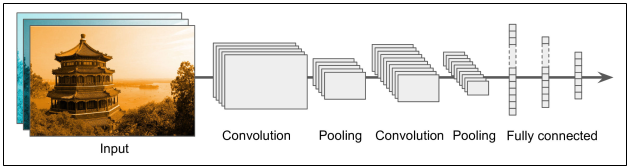

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])


• In this code, we start by using the partial() function to define a thin wrapper
around the Conv2D class, called DefaultConv2D : it simply avoids having to repeat
the same hyperparameter values over and over again.


• The first layer uses a large kernel size, but no stride because the input images are
not very large. It also sets input_shape=[28, 28, 1] , which means the images
are 28 × 28 pixels, with a single color channel (i.e., grayscale).


• Next, we have a max pooling layer, which divides each spatial dimension by a fac‐
tor of two (since pool_size=2 ).


• Then we repeat the same structure twice: two convolutional layers followed by a
max pooling layer. For larger images, we could repeat this structure several times
(the number of repetitions is a hyperparameter you can tune).


• Note that the number of filters grows as we climb up the CNN towards the out‐
put layer (it is initially 64, then 128, then 256): it makes sense for it to grow, since
the number of low level features is often fairly low (e.g., small circles, horizontal
lines, etc.), but there are many different ways to combine them into higher level
features. It is a common practice to double the number of filters after each pool‐
ing layer: since a pooling layer divides each spatial dimension by a factor of 2, we
can afford doubling the number of feature maps in the next layer, without fear of
exploding the number of parameters, memory usage, or computational load.


• Next is the fully connected network, composed of 2 hidden dense layers and a
dense output layer. Note that we must flatten its inputs, since a dense network
expects a 1D array of features for each instance. We als

**N.B**:  **A common mistake is to use convolution kernels that are too large.
For example, instead of using a convolutional layer with a 5 × 5
kernel, it is generally preferable to stack two layers with 3 × 3 ker‐
nels: it will use less parameters and require less computations, and
it will usually perform better. One exception to this recommenda‐
tion is for the first convolutional layer: it can typically have a large
kernel (e.g., 5 × 5), usually with stride of 2 or more: this will reduce
the spatial dimension of the image without losing too much infor‐
mation, and since the input image only has 3 channels in general, it
will not be too costly.**

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 39s 21ms/step - loss: 0.7065 - accuracy: 0.7497 - val_loss: 0.3909 - val_accuracy: 0.8594
Epoch 2/10
1719/1719 [==============================] - 35s 21ms/step - loss: 0.4183 - accuracy: 0.8577 - val_loss: 0.3393 - val_accuracy: 0.8742
Epoch 3/10
1719/1719 [==============================] - 35s 21ms/step - loss: 0.3656 - accuracy: 0.8769 - val_loss: 0.3122 - val_accuracy: 0.8880
Epoch 4/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3260 - accuracy: 0.8898 - val_loss: 0.2744 - val_accuracy: 0.8946
Epoch 5/10
1719/1719 [==============================] - 35s 21ms/step - loss: 0.3078 - accuracy: 0.8943 - val_loss: 0.2729 - val_accuracy: 0.9008
Epoch 6/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.2897 - accuracy: 0.9009 - val_loss: 0.2810 - val_accuracy: 0.8954
Epoch 7/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.2725 - accuracy: 0.9068 - val_loss: 0.2814 -

**This CNN reaches over 88% accuracy on the test set. It’s not the state of the art, but it
is pretty good, and clearly much better than what we achieved with dense networks in
Chapter 10**

**LETNET**

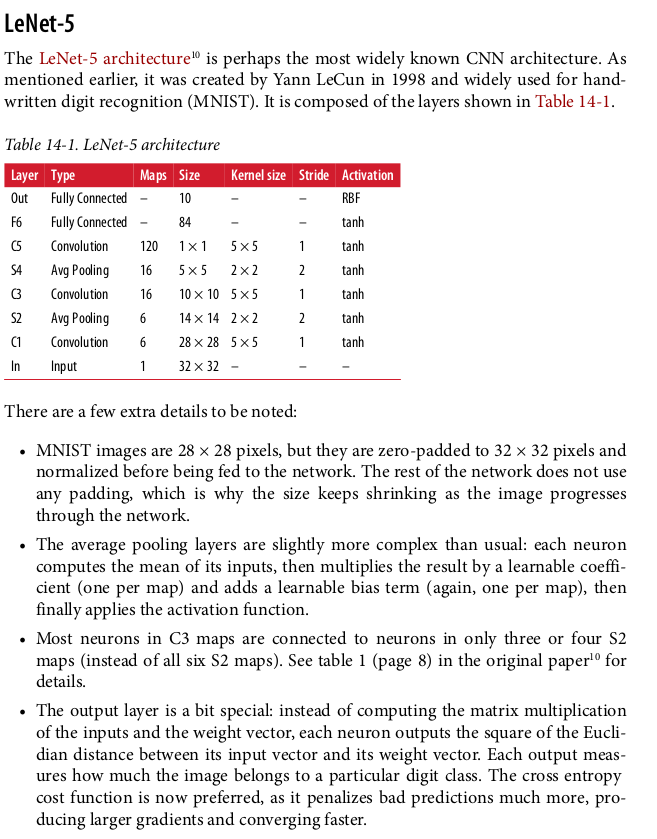



**ALEXNET**

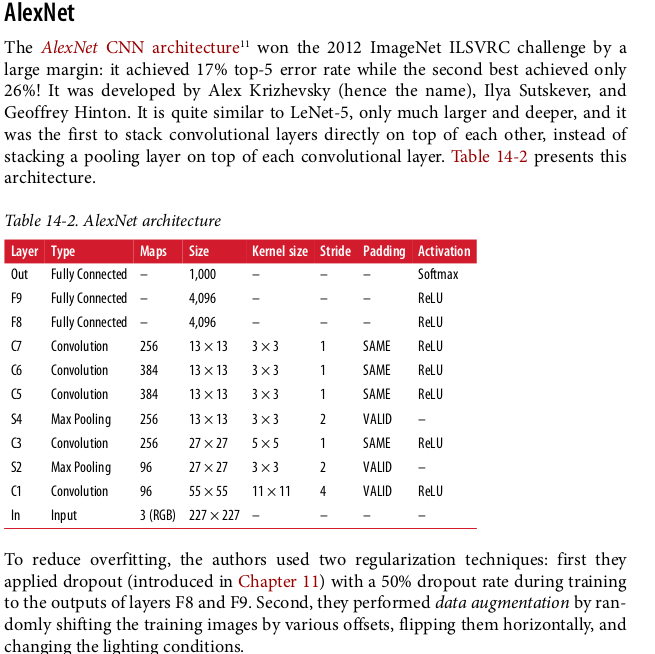

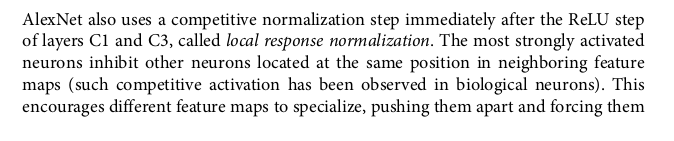

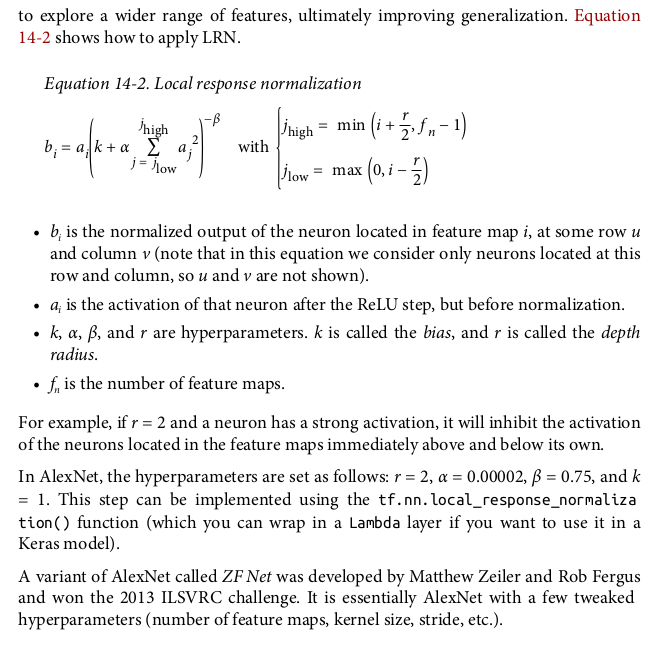

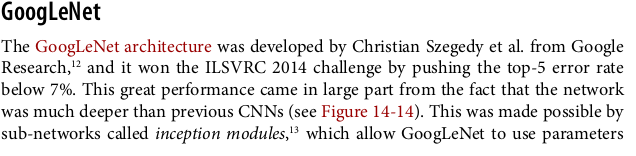

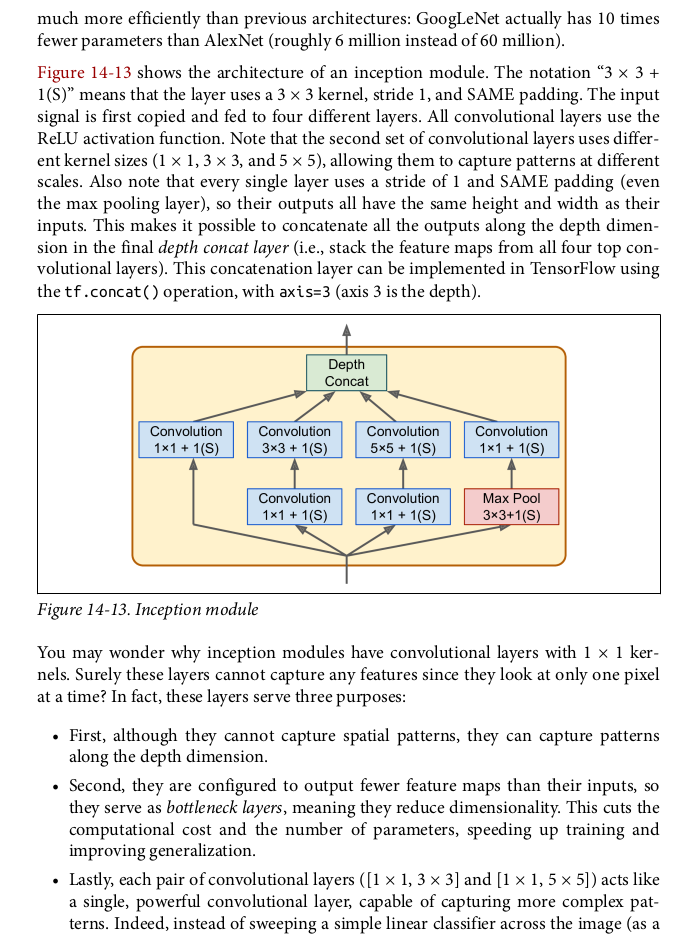

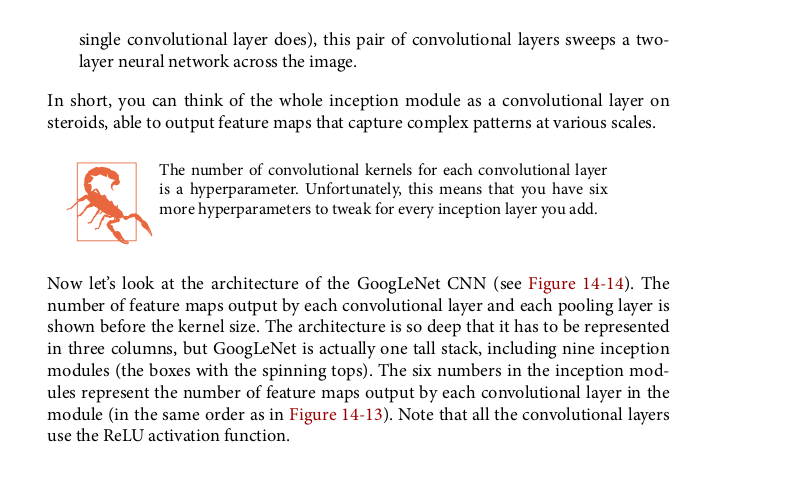

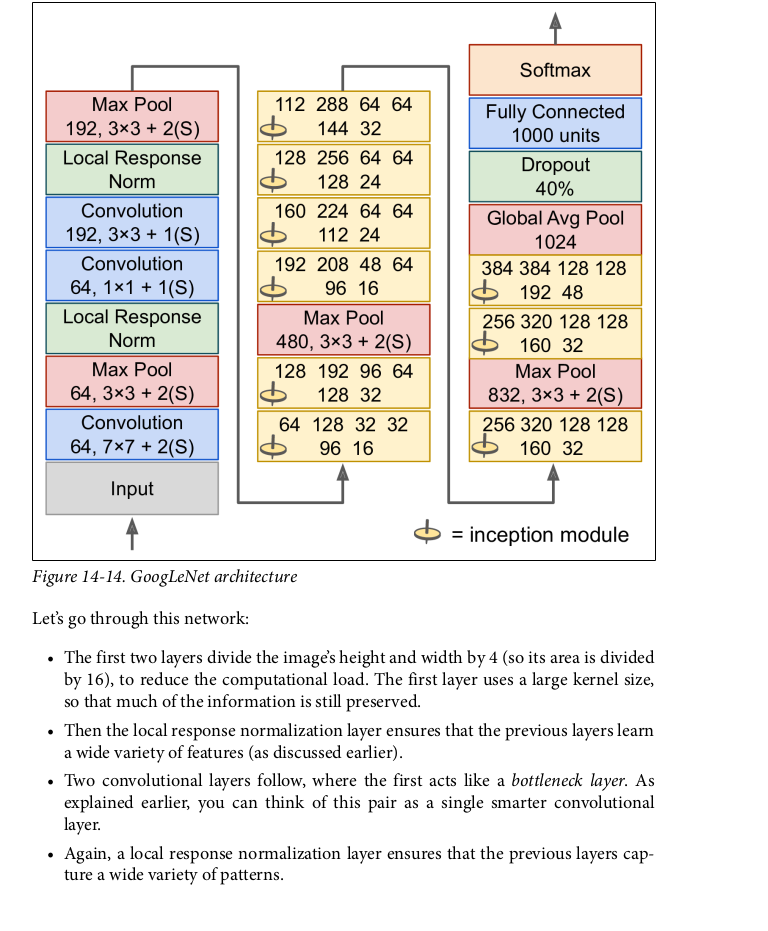

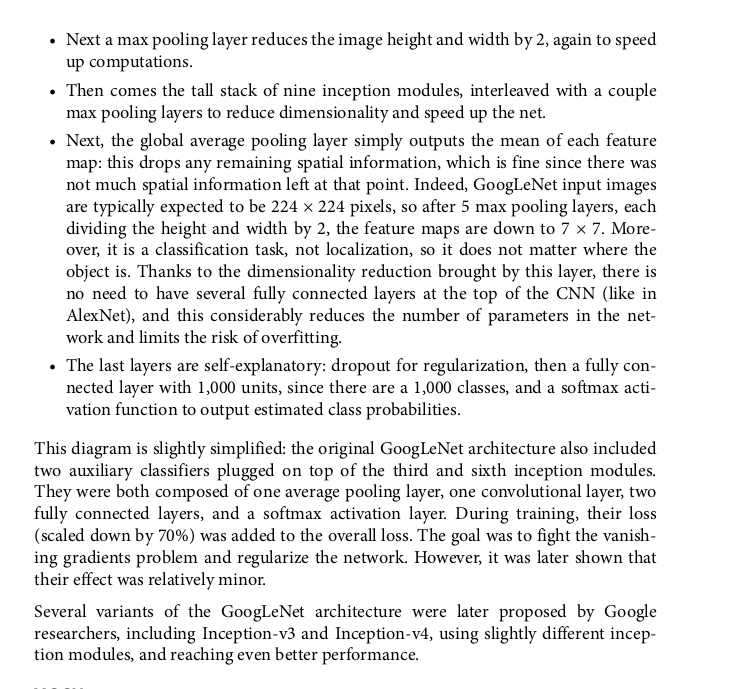

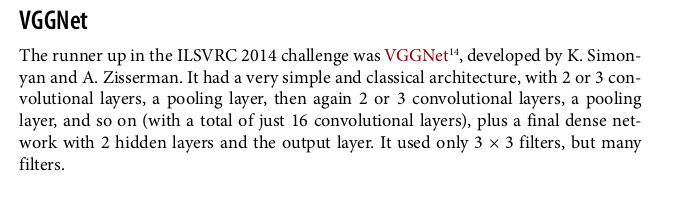

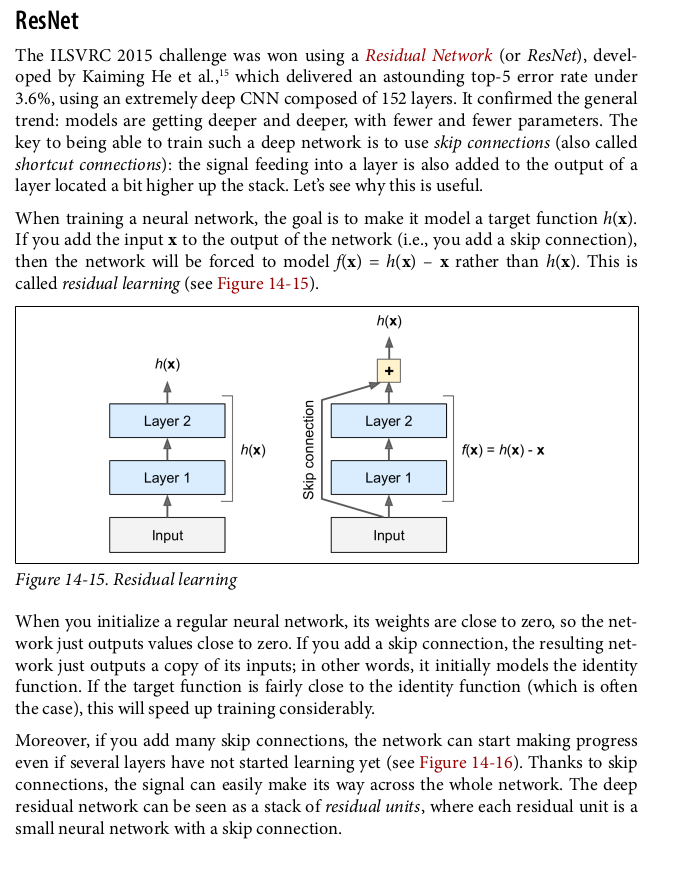

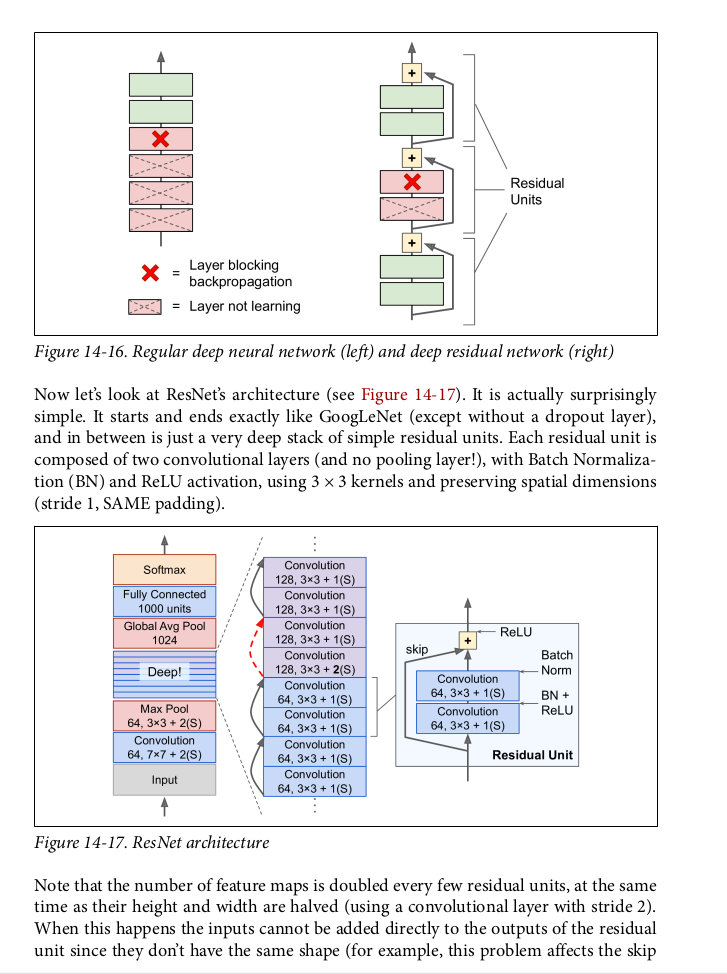

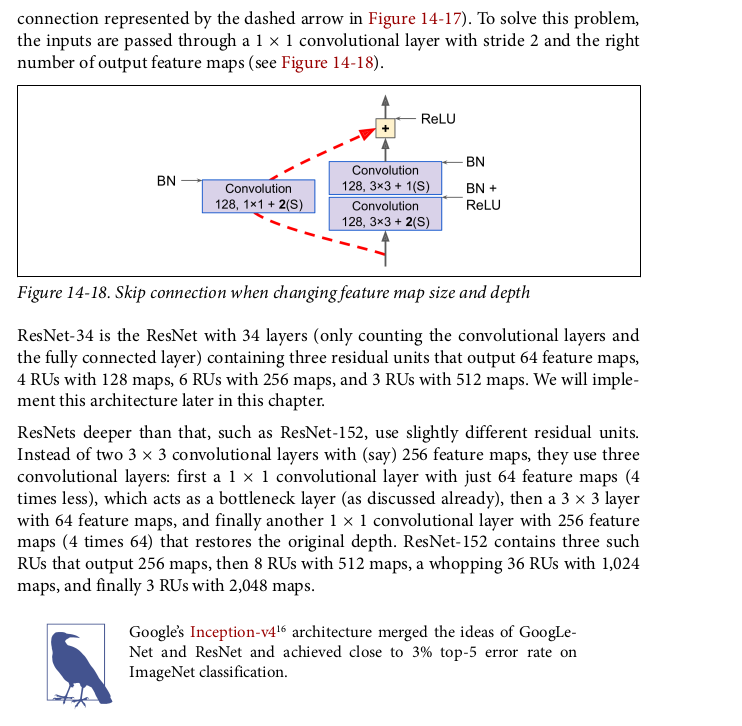

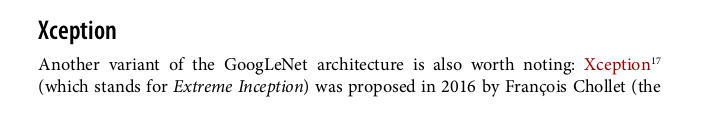

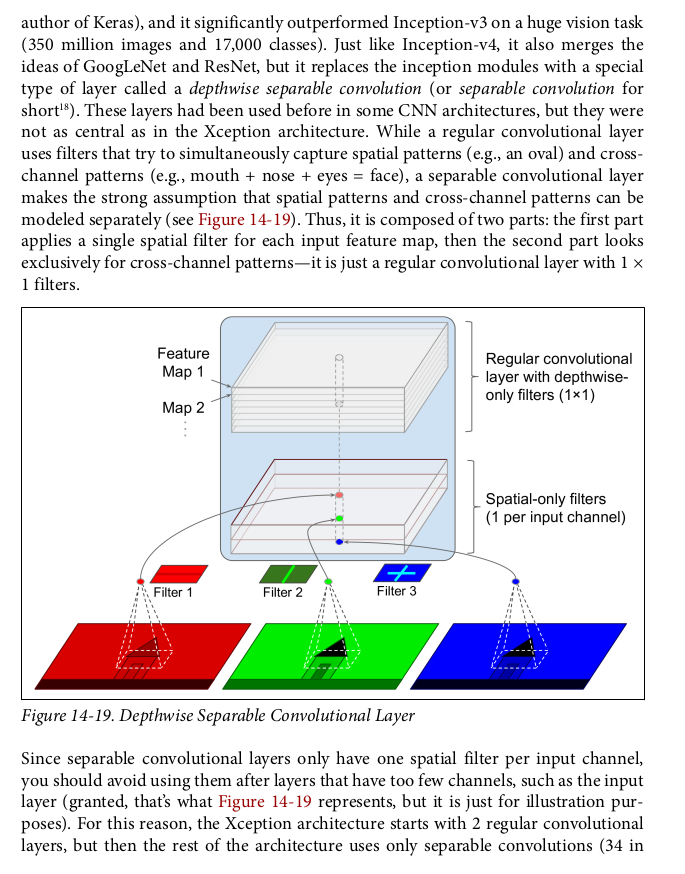

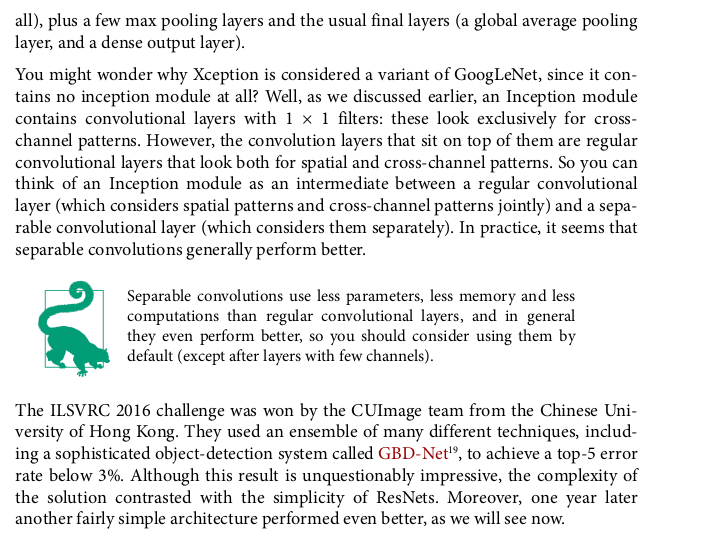

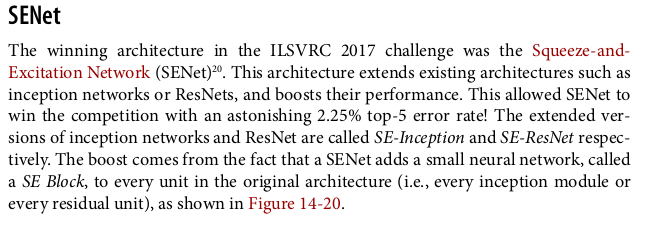

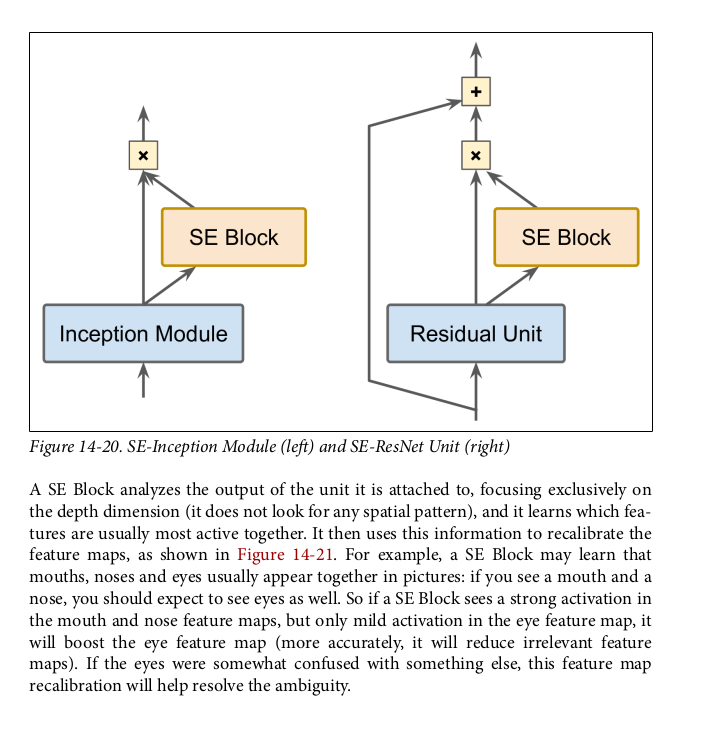

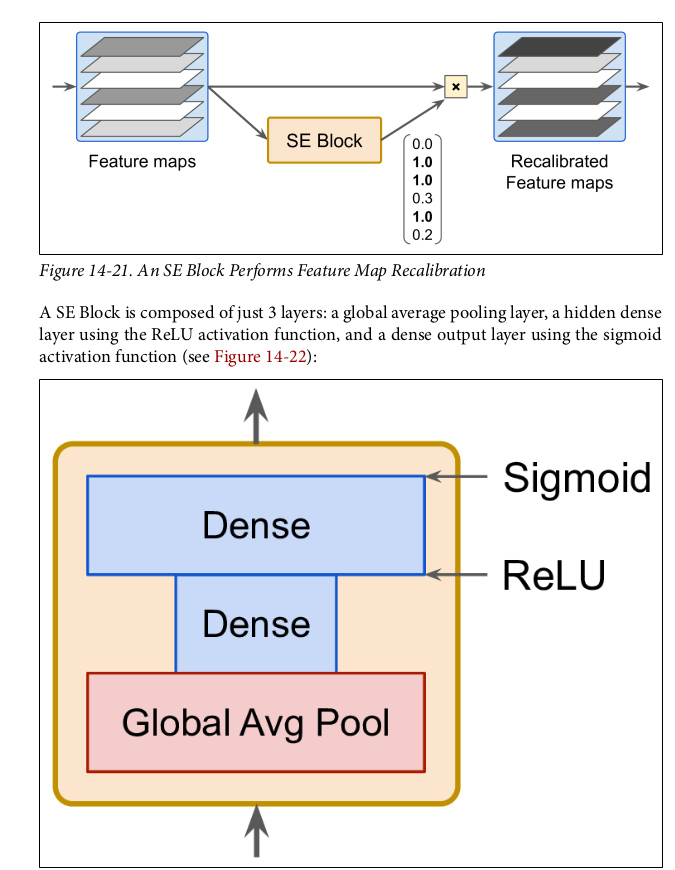

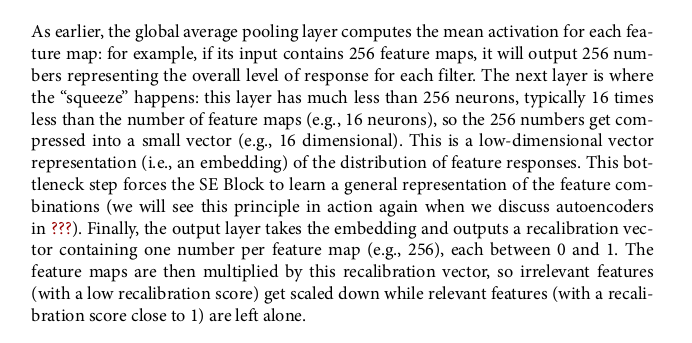

## **Implementing ResNet CNN**

In [ ]:
# using OOP from scratch

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)




**In the constructor, we
create all the layers we will need: the main layers are the ones on the right side of the
diagram, and the skip layers are the ones on the left (only needed if the stride is
greater than 1). Then in the call() method, we simply make the inputs go through
the main layers, and the skip layers (if any), then we add both outputs and we apply
the activation function.**

**Next, we can build the ResNet-34 simply using a Sequential model, since it is really
just a long sequence of layers (we can treat each residual unit as a single layer now
that we have the ResidualUnit class)**

In [ ]:
# using keras
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

**The only slightly tricky part in this code is the loop that adds the ResidualUnit layers
to the model: as explained earlier, the first 3 RUs have 64 filters, then the next 4 RUs
have 128 filters, and so on. We then set the strides to 1 when the number of filters is
the same as in the previous RU, or else we set it to 2. Then we add the ResidualUnit ,
and finally we update prev_filters**


**It is quite amazing that in less than 40 lines of code, we can build the model that won
the ILSVRC 2015 challenge! It demonstrates both the elegance of the ResNet model,
and the expressiveness of the Keras API. Implementing the other CNN architectures
is not much harder. However, Keras comes with several of these architectures built in,
so why not use them instead?**

# Pretrained Models from keras

**That’s all! This will create a ResNet-50 model and download weights pretrained on
the ImageNet dataset. To use it, you first need to ensure that the images have the right
size. A ResNet-50 model expects 224 × 224 images (other models may expect other
sizes, such as 299 × 299), so let’s use TensorFlow’s tf.image.resize() function to
resize the images we loaded earlier:**

102981632/102967424 [==============================] - 2s 0us/step


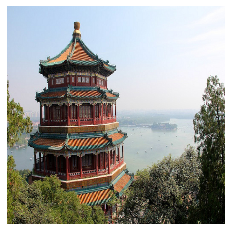

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


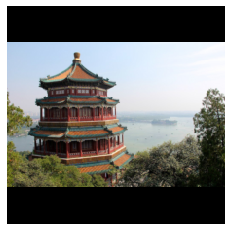

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

**Making predictions using pretrained models**

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

**As usual, the output Y_proba is a matrix with one row per image and one column per
class (in this case, there are 1,000 classes). If you want to display the top K predic‐
tions, including the class name and the estimated probability of each predicted class,
you can use the decode_predictions() function. For each image, it returns an array
containing the top K predictions, where each prediction is represented as an array
containing the class identifier 21 , its name and the corresponding confidence score**

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03028079 - church       26.16%
  n04346328 - stupa        23.96%
  n02980441 - castle       17.40%

Image #1
  n11939491 - daisy        15.94%
  n03530642 - honeycomb    15.29%
  n04522168 - vase         9.32%



**The correct classes (monastery and daisy) appear in the top 3 results for both images.
That’s pretty good considering that the model had to choose among 1,000 classes.
As you can see, it is very easy to create a pretty good image classifier using a pre‐
trained model. Other vision models are available in keras.applications , including
several ResNet variants, GoogLeNet variants like InceptionV3 and Xception,
VGGNet variants, MobileNet and MobileNetV2 (lightweight models for use in
mobile applications), and more.
But what if you want to use an image classifier for classes of images that are not part
of ImageNet? In that case, you may still benefit from the pretrained models to per‐
form transfer learning.**

# **Classification & Localisation**

**Localizing an object in a picture can be expressed as a regression task to predict a bounding box around the object, a common approach is to
predict the horizontal and vertical coordinates of the object’s center, as well as its
height and width. This means we have 4 numbers to predict. It does not require much
change to the model, we just need to add a second dense output layer with 4 units
(typically on top of the global average pooling layer), and it can be trained using the
MSE loss:**

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(5, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer="nadam", metrics=["accuracy"])

**But now we have a problem: the flowers dataset does not have bounding boxes
around the flowers. So we need to add them ourselves. This is often one of the hard‐
est and most costly part of a Machine Learning project: getting the labels. It’s a good
idea to spend time looking for the right tools. To annotate images with bounding
boxes, you may want to use an open source image labeling tool like VGG Image
Annotator, LabelImg, OpenLabeler or ImgLab, or perhaps a commercial tool like
LabelBox or Supervisely. You may also want to consider crowdsourcing platforms
such as Amazon Mechanical Turk or CrowdFlower if you have a very large number of
images to annotate. However, it is quite a lot of work to setup a crowdsourcing plat‐
form, prepare the form to be sent to the workers, to supervise them and ensure the
quality of the bounding boxes they produce is good, so make sure it is worth the
effort: if there are just a few thousand images to label, and you don’t plan to do this
frequently, it may be preferable to do it yourself. Adriana Kovashka et al. wrote a very
practical paper 22 about crowdsourcing in Computer Vision, I recommend you check
it out, even if you do not plan to use crowdsourcing.
So let’s suppose you obtained the bounding boxes for every image in the flowers data‐
set (for now we will assume there is a single bounding box per image), you then need
to create a dataset whose items will be batches of preprocessed images along with
their class labels and their bounding boxes. Each item should be a tuple of the form:
(images, (class_labels, bounding_boxes)) . Then you are ready to train your
model!
The bounding boxes should be normalized so that the horizontal
and vertical coordinates, as well as the height and width all range
from 0 to 1. Also, it is common to predict the square root of the
height and width rather than the height and width directly: this
way, a 10 pixel error for a large bounding box will not be penalized
as much as a 10 pixel error for a small bounding box.
The MSE often works fairly well as a cost function to train the model, but it is not a
great metric to evaluate how well the model can predict bounding boxes. The most
common metric for this is the Intersection over Union (IoU): it is the area of overlap
between the predicted bounding box and the target bounding box, divided by the
area of their union (see Figure 14-23). In tf.keras, it is implemented by the
tf.keras.metrics.MeanIoU class.**

In [ ]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

model.fit(fake_train_set, steps_per_epoch=5, epochs=2)


## **Object Detection with YOLO & FCN**

**See Documentation**

**